# Creating custom indicator based strategy

In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import date
plt.style.use('fivethirtyeight')
yf.pdr_override()

In [34]:
stocksymbols = ['WIPRO.NS']
startdate = date(2021,12,1)
end_date = date.today()
print(end_date)
def getMyPortfolio(stocks = stocksymbols ,start = startdate , end = end_date):
    data = web.get_data_yahoo(stocks , data_source='yahoo' , start = start ,end= end )
    return data

2022-10-31


### Getting data for strategy building

In [35]:
data = getMyPortfolio(stocksymbols)


[*********************100%***********************]  1 of 1 completed


### Testing simple moving average of 20,50

In [36]:
data['SMA 20'] = ta.sma(data['Close'],20)
data['SMA 50'] = ta.sma(data['Close'],50)

def buy_sell(data):
    signalBuy = []
    signalSell = []
    position = False 

    for i in range(len(data)):
        if data['SMA 20'][i] > data['SMA 50'][i]:
            if position == False :
                signalBuy.append(data['Adj Close'][i])
                signalSell.append(np.nan)
                position = True
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        elif data['SMA 20'][i] < data['SMA 50'][i]:
            if position == True:
                signalBuy.append(np.nan)
                signalSell.append(data['Adj Close'][i])
                position = False
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        else:
            signalBuy.append(np.nan)
            signalSell.append(np.nan)
    return pd.Series([signalBuy, signalSell])




In [37]:
data['Buy_Signal_price'], data['Sell_Signal_price'] = buy_sell(data)


## Buying/ Selling on Crossovers

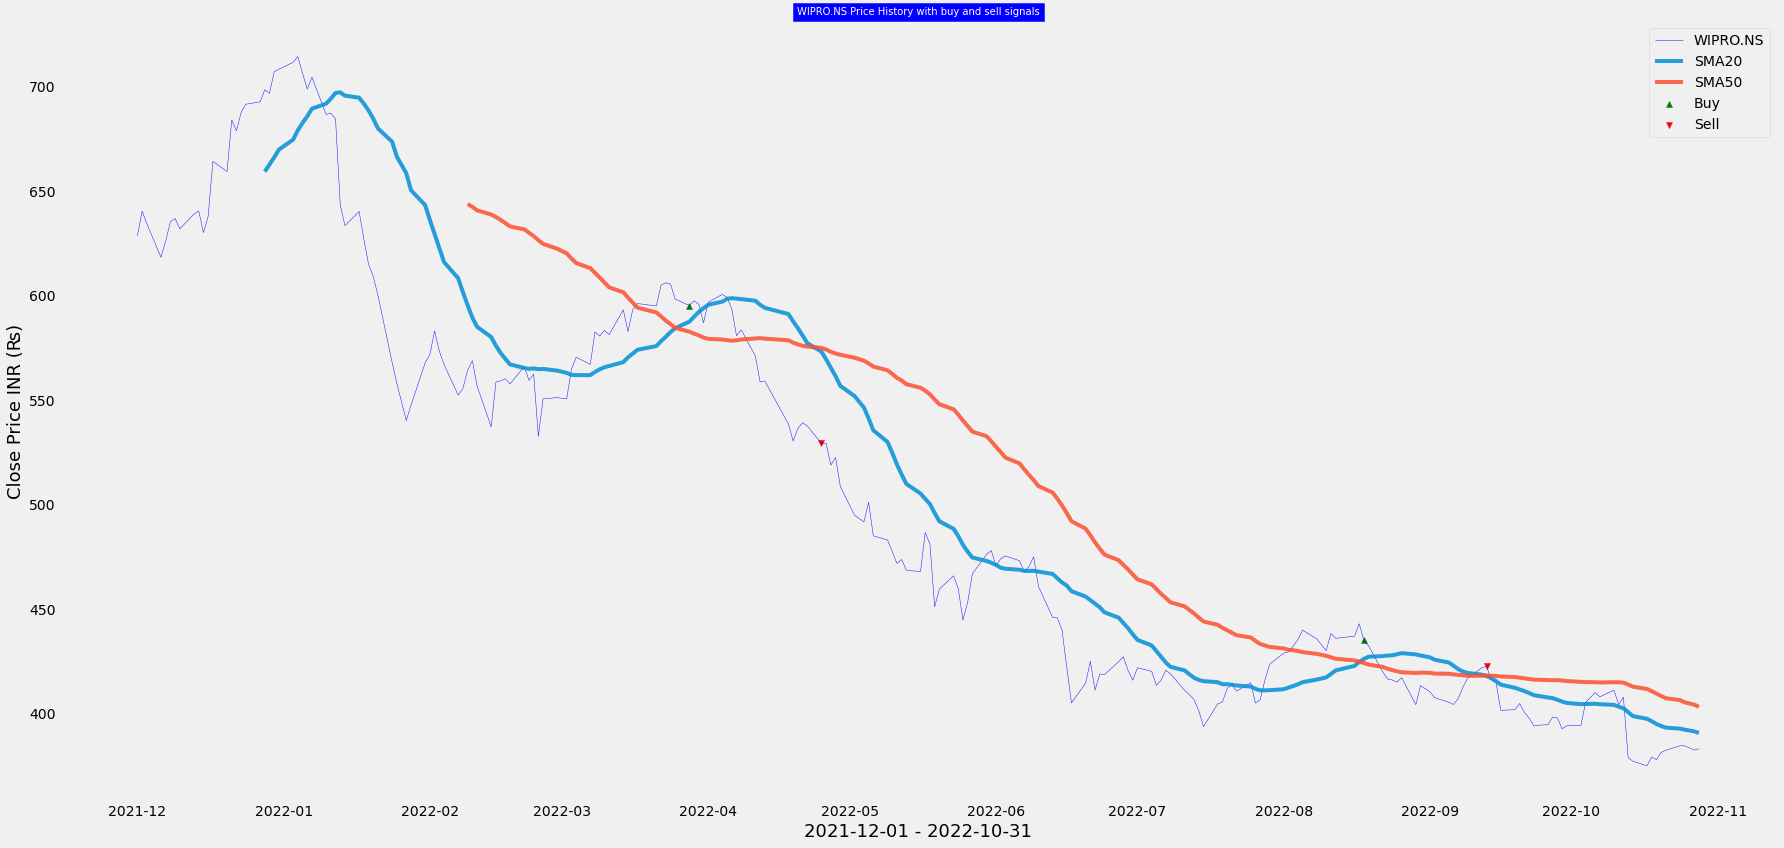

In [38]:
fig, ax = plt.subplots(figsize=(25,12))
ax.plot(data['Adj Close'] , label = stocksymbols[0] ,linewidth=0.5, color='blue', alpha = 0.9)
ax.plot(data['SMA 20'], label = 'SMA20', alpha = 0.85)
ax.plot(data['SMA 50'], label = 'SMA50' , alpha = 0.85)
ax.scatter(data.index , data['Buy_Signal_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
ax.scatter(data.index , data['Sell_Signal_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
ax.set_title(stocksymbols[0] + " Price History with buy and sell signals",fontsize=10, backgroundcolor='blue', color='white')
ax.set_xlabel(f'{startdate} - {end_date}' ,fontsize=18)
ax.set_ylabel('Close Price INR (₨)' , fontsize=18)
legend = ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## Testing MACD indicator

In [39]:
macd = ta.macd(data['Close'])



In [40]:
data = pd.concat([data, macd], axis=1).reindex(data.index)

In [41]:
def MACD_Strategy(df, risk):
    MACD_Buy=[]
    MACD_Sell=[]
    position=False

    for i in range(0, len(df)):
        if df['MACD_12_26_9'][i] > df['MACDs_12_26_9'][i] :
            MACD_Sell.append(np.nan)
            if position ==False:
                MACD_Buy.append(df['Adj Close'][i])
                position=True
            else:
                MACD_Buy.append(np.nan)
        elif df['MACD_12_26_9'][i] < df['MACDs_12_26_9'][i] :
            MACD_Buy.append(np.nan)
            if position == True:
                MACD_Sell.append(df['Adj Close'][i])
                position=False
            else:
                MACD_Sell.append(np.nan)
        elif position == True and df['Adj Close'][i] < MACD_Buy[-1] * (1 - risk):
            MACD_Sell.append(df["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        elif position == True and df['Adj Close'][i] < df['Adj Close'][i - 1] * (1 - risk):
            MACD_Sell.append(df["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        else:
            MACD_Buy.append(np.nan)
            MACD_Sell.append(np.nan)

    data['MACD_Buy_Signal_price'] = MACD_Buy
    data['MACD_Sell_Signal_price'] = MACD_Sell


In [42]:
MACD_strategy = MACD_Strategy(data, 0.025)

In [43]:
def MACD_color(data):
    MACD_color = []
    for i in range(0, len(data)):
        if data['MACDh_12_26_9'][i] > data['MACDh_12_26_9'][i - 1]:
            MACD_color.append(True)
        else:
            MACD_color.append(False)
    return MACD_color

data['positive'] = MACD_color(data)



### Buy when 12 period ema > 26 period ema
### Sell when 26 period ema > 12 period ema

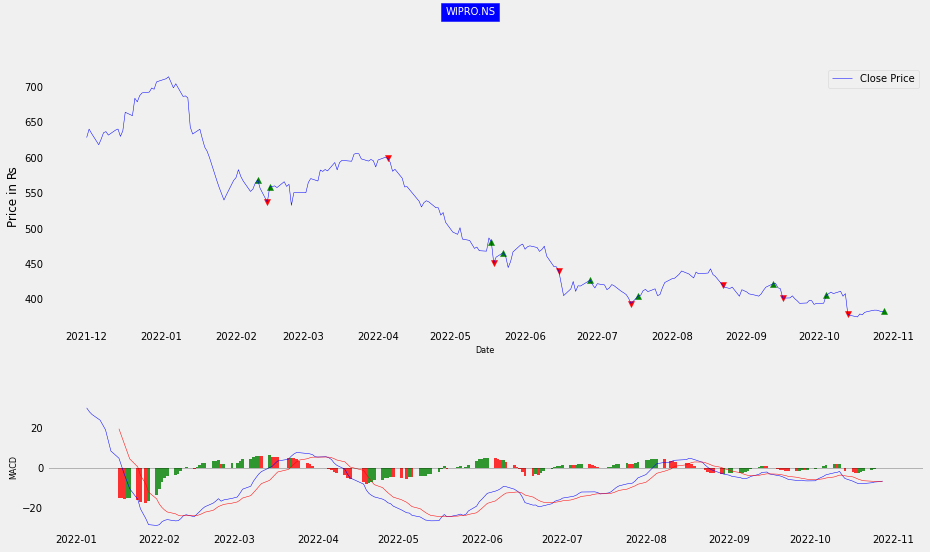

In [44]:
plt.rcParams.update({'font.size': 10})
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(stocksymbols[0], fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price in ₨')
ax1.plot('Adj Close',data=data, label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(data.index, data['MACD_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(data.index, data['MACD_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.set_ylabel('MACD', fontsize=8)
ax2.plot('MACD_12_26_9', data=data, label='MACD', linewidth=0.5, color='blue')
ax2.plot('MACDs_12_26_9', data=data, label='signal', linewidth=0.5, color='red')
ax2.bar(data.index,'MACDh_12_26_9', data=data, label='Volume', color=data.positive.map({True: 'g', False: 'r'}),width=1,alpha=0.8)
ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax2.grid()
plt.show()


### Testing bollinger band strategy

In [45]:
def bb_strategy(data):
    bbBuy = []
    bbSell = []
    position = False
    bb = ta.bbands(data['Adj Close'], length=20,std=2)
    data = pd.concat([data, bb], axis=1).reindex(data.index)

    for i in range(len(data)):
        if data['Adj Close'][i] < data['BBL_20_2.0'][i]:
            if position == False :
                bbBuy.append(data['Adj Close'][i])
                bbSell.append(np.nan)
                position = True
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        elif data['Adj Close'][i] > data['BBU_20_2.0'][i]:
            if position == True:
                bbBuy.append(np.nan)
                bbSell.append(data['Adj Close'][i])
                position = False #To indicate that I actually went there
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        else :
            bbBuy.append(np.nan)
            bbSell.append(np.nan)

    data['bb_Buy_Signal_price'] = bbBuy
    data['bb_Sell_Signal_price'] = bbSell

    return data


In [46]:
data = bb_strategy(data)

### Buying when price at lowerband
### Selling when price at upperband

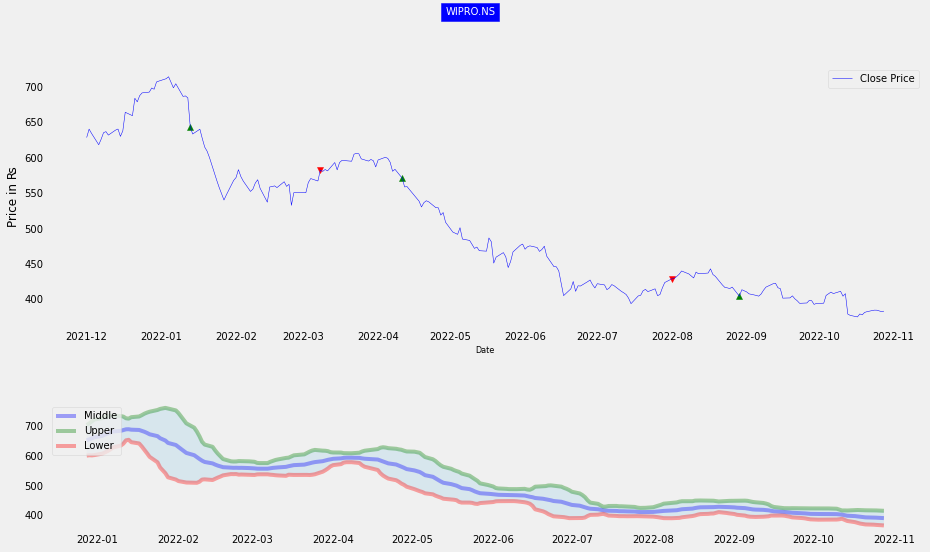

In [47]:
#plot
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(stocksymbols[0], fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price in ₨')
ax1.plot(data['Adj Close'],label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(data.index, data['bb_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(data.index, data['bb_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.plot(data['BBM_20_2.0'], label='Middle', color='blue', alpha=0.35) #middle band
ax2.plot(data['BBU_20_2.0'], label='Upper', color='green', alpha=0.35) #Upper band
ax2.plot(data['BBL_20_2.0'], label='Lower', color='red', alpha=0.35) #lower band
ax2.fill_between(data.index, data['BBL_20_2.0'], data['BBU_20_2.0'], alpha=0.1)
ax2.legend(loc='upper left')
ax2.grid()
plt.show()
